## Use EntanglementGenerationA and BSMNode to generate entanglement
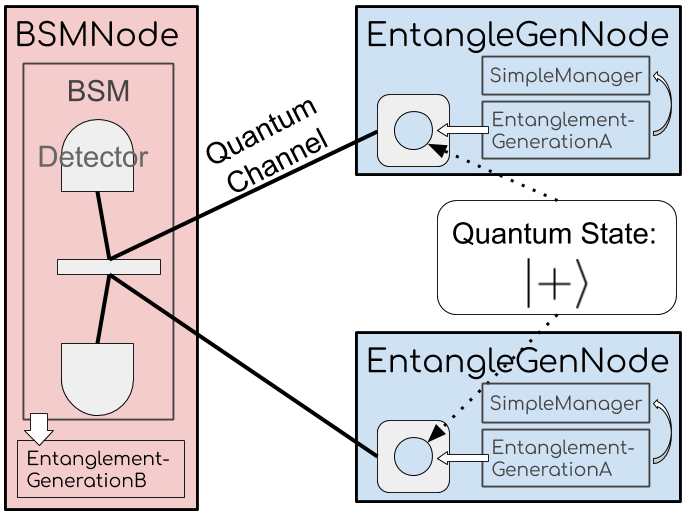
We will show

how to use **EntanglementGenerationA** (Barret-Kok generation protocol) to entangle memories on different nodes

how to use **BBPSSW** (BBPSSW purification protocol) to improve the fidelity of entanglement

how to use **EntanglementSwappingA** and **EntanglementSwappingB** (swapping protocol) to extend the distance of entanglement

The Barrett-Kok generation protocol is a method used to entangle quantum memories located at different nodes in a quantum network

The above figure shows the network topology used in this example. The network includes three nodes: one BSMNode node and two EntangleGenNode nodes. The BSMNode node comes from SeQUeNCe. We will build the custom node EntangleGenNode that inherits the Node class from SeQUeNCe. Two quantum channels connect the BSMNode with the two EntangleGenNode. Classical channels and nodes create a complete classical graph, which is not shown in the figure.

**BSMNode** includes:

**Hardware**: two detectors in a bell state measurement device (BSM) to record the arrival time of photons.

**Software**: the EntanglementGenerationB protocol to collect the arrival time of photons and notify the EntanglementGenerationA protocols on the other nodes.

**EntangleGenNode includes**:

**Hardware**: one quantum memory in the |+⟩ state, prepared to entangle with the remote memory on the other node.

**Software**: the EntanglementGenerationA protocol to excite the controlled memory and determine the quantum state via messages from EntanglementGenerationB; a SimpleManager which uses the update function to get the state of the memory after the procedures in EntanglementGenerationA.

## Step 1 Customize Node
We can import BSMNode from SeQUeNCe package and thus only need to define the EntangleGenNode class. We also define our SimpleManager, which will create entanglement protocol instances and monitor their success. The code for the EntangleGenNode and SimpleManager classes is shown below

In [18]:
from sequence.topology.node import Node
from sequence.components.memory import Memory
from sequence.entanglement_management.generation import EntanglementGenerationA
from sequence.kernel.timeline import Timeline


class SimpleManager:
    def __init__(self, own, memo_name):
        self.own = own
        self.memo_name = memo_name
        self.raw_counter = 0
        self.ent_counter = 0

    def update(self, protocol, memory, state):
        if state == 'RAW':
            self.raw_counter += 1
            memory.reset()
        else:
            self.ent_counter += 1

    def create_protocol(self, middle: str, other: str):
        self.own.protocols = [EntanglementGenerationA(self.own, '%s.eg' % self.own.name, middle, other,
                                                      self.own.components[self.memo_name])]


class EntangleGenNode(Node):
    def __init__(self, name: str, tl: Timeline):
        super().__init__(name, tl)

        memo_name = '%s.memo' % name
        memory = Memory(memo_name, tl, 0.9, 2000, 1, -1, 500)
        memory.owner = self
        memory.add_receiver(self)
        self.add_component(memory)

        self.resource_manager = SimpleManager(self, memo_name)

    def init(self):
        memory = self.get_components_by_type("Memory")[0]
        memory.reset()

    def receive_message(self, src: str, msg: "Message") -> None:
        self.protocols[0].received_message(src, msg)

    def get(self, photon, **kwargs):
        self.send_qubit(kwargs['dst'], photon)

In this customized Node class, we overwrite the init, receive_message, and get methods. The init method will be used to reset the local memory at the beginning of the simulation. The get method directs received photons from the memory to the attached quantum channel, as discussed in the previous tutorial. Finally, for the receive_message method, the node will receive a classical message msg from the source node src.

We also add a function create_protocol(self, middle: str, other: str) to the manager to create the local instance of the generation protocol. The middle and other parameters declare the name of the BSMNode and EntangleGenNode, respectively, used for generating entanglement.
The constructor function of EntanglementGenerationA needs five arguments:

1.the node that holds the protocol instance

2.the identity (name) of the protocol instance

3.the name of the BSMNode involved in entanglement generation

4.the name of the remote EntangleGenNode involved in entanglement generation

5.the memory used for generating entanglement

## Step 2 Create Netwoork

As introduced in the previous chapter, we create nodes and channels to define the network. To avoid unnecessary errors, we will set the efficiency of our detectors to 1

In [19]:
from sequence.kernel.timeline import Timeline
from sequence.topology.node import BSMNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel


tl = Timeline()

node1 = EntangleGenNode('node1', tl)
node2 = EntangleGenNode('node2', tl)
bsm_node = BSMNode('bsm_node', tl, ['node1', 'node2'])
node1.set_seed(0)
node2.set_seed(1)
bsm_node.set_seed(2)

bsm = bsm_node.get_components_by_type("SingleAtomBSM")[0]
bsm.update_detectors_params('efficiency', 1)

qc1 = QuantumChannel('qc1', tl, attenuation=0, distance=1000)
qc2 = QuantumChannel('qc2', tl, attenuation=0, distance=1000)
qc1.set_ends(node1, bsm_node.name)
qc2.set_ends(node2, bsm_node.name)

nodes = [node1, node2, bsm_node]

for i in range(3):
    for j in range(3):
        cc= ClassicalChannel('cc_%s_%s'%(nodes[i].name, nodes[j].name), tl, 1000, 1e8)
        cc.set_ends(nodes[i], nodes[j].name)

## Step 3: Configure and Start the EntanglementGenerationA Protocol
First, we will use create_protocol to create the instance of the protocol on the node. Before we start the protocol, we need to pair the protocols on the two nodes. The function pair_protocol defined here uses two EntangleGenNode as the input and will pair all necessary protocols. The protocols in EntangleGenNode.protocols are paired with the set_others method.

Now, the protocols are ready to start generating entanglement and we can start our experiment.

In [20]:
from sequence.entanglement_management.entanglement_protocol import EntanglementProtocol


def pair_protocol(node1: Node, node2: Node):
    p1 = node1.protocols[0]
    p2 = node2.protocols[0]
    node1_memo_name = node1.get_components_by_type("Memory")[0].name
    node2_memo_name = node2.get_components_by_type("Memory")[0].name
    p1.set_others(p2.name, node2.name, [node2_memo_name])
    p2.set_others(p1.name, node1.name, [node1_memo_name])


node1.resource_manager.create_protocol('bsm_node', 'node2')
node2.resource_manager.create_protocol('bsm_node', 'node1')
pair_protocol(node1, node2)

memory = node1.get_components_by_type("Memory")[0]

print('before', memory.entangled_memory, memory.fidelity)
# "before node1.memo {'node_id': None, 'memo_id': None} 0"

tl.init()
node1.protocols[0].start()
node2.protocols[0].start()
tl.run()

print('after', memory.entangled_memory, memory.fidelity)
# (if the generation fails) "after node1.memo {'node_id': None, 'memo_id': None} 0"
# (if the generation succeeds) "after node1.memo {'node_id': 'node2', 'memo_id': 'node2.memo'} 0.9"

before {'node_id': None, 'memo_id': None} 0
after {'node_id': None, 'memo_id': None} 0


## Step 4: Try to Generate Entanglement Multiple Times
The mechanism of the Barrett-Kok generation protocol can achieve at most 50% success rate. We can, however, set the protocol to try multiple times and observe the success rate of protocol. We will use the Memory.reset() method to reset the state of quantum memories before restarting protocols.

In [21]:
tl.init()
for i in range(1000):
    tl.time = tl.now() + 1e11
    node1.resource_manager.create_protocol('bsm_node', 'node2')
    node2.resource_manager.create_protocol('bsm_node', 'node1')
    pair_protocol(node1, node2)

    node1.protocols[0].start()
    node2.protocols[0].start()
    tl.run()

print("node1 entangled memories : available memories")
print(node1.resource_manager.ent_counter, ':', node1.resource_manager.raw_counter)
# (around 500:500; the exact number depends on the seed of numpy.random)

node1 entangled memories : available memories
499 : 502


## Example: Use BBPSSW to improve the fidelity of entanglement 
The above figure shows the network topology of this example